# Definição da Região de estudo
- Escolhida a região do **Distrito Federal** para análise:  
  - **Área pequena:**  
    - Redução de cálculos geoespaciais  
    - Redução de erros ao se atribuir propriedades aos trechos das estradas às estações próximas  
  - **Longo período de dados extraídos**  
  - **Área interna ao país:**  
    - Não faz fronteira com outros países  
    - Fronteira apenas com GO e MG  
      - Redução de estações analisadas  
    - Envolto à malha de estações automáticas do BR  



In [23]:
import pandas as pd
import glob
import os
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
from geobr import read_state
from shapely.ops import unary_union
from geobr import read_country
import contextily as ctx
from pathlib import Path
from datetime import datetime
from unidecode import unidecode
import numpy as np
import chardet
import srtm
from geopy.distance import geodesic
from shapely.geometry import LineString, Point, MultiLineString
from shapely.ops import linemerge
import plotly_express as px


def plot_brs(
    gdf,
    accidents_df=None,
    points_list=None,
    df_estacoes=None,
    highway_color='navy',
    highway_linewidth=2.5,
    accident_color='red',
    accident_linewidth=1,
    accident_markersize=50,
    station_color='blue',
    station_marker='o',
    station_markersize=40,
    extent=None,
    zoom=10
):
    """
    Plota rodovias sobre OSM, adiciona (opcionalmente):
      • acidentes a partir de um DataFrame (latitude_acidente, longitude_acidente)
      • pontos customizados (lat, lon, descrição, cor)
      • estações a partir de um DataFrame (latitude, longitude)
    Rodovias são desenhadas por último.

    Parâmetros:
    - gdf: GeoDataFrame de linhas (qualquer CRS)
    - accidents_df: pd.DataFrame com colunas 'latitude_acidente', 'longitude_acidente'
    - points_list: list of [lat, lon, descrição, cor]
    - df_estacoes: pd.DataFrame com colunas 'latitude', 'longitude'
    - highway_color, highway_linewidth: estilo das rodovias
    - accident_color, accident_linewidth, accident_markersize: estilo dos acidentes
    - station_color, station_marker, station_markersize: estilo das estações
    - extent: (minx, miny, maxx, maxy) em EPSG:3857
    - zoom: nível de zoom do basemap
    """
    # 1) Reprojeta rodovias
    gdf_3857 = gdf.to_crs(epsg=3857)

    # 2) Define extent
    if extent is None:
        minx, miny, maxx, maxy = gdf_3857.total_bounds
    else:
        minx, miny, maxx, maxy = extent

    # 3) Cria figura e ajusta limites antes do basemap
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # 4) Desenha basemap sem alterar limites
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        zoom=zoom,
        reset_extent=False
    )

    # 5) Plota acidentes_df, se fornecido
    if accidents_df is not None:
        ac_gdf = (
            gpd.GeoDataFrame(
                accidents_df,
                geometry=gpd.points_from_xy(
                    accidents_df.longitude_acidente,
                    accidents_df.latitude_acidente
                ),
                crs="EPSG:4326"
            )
            .to_crs(epsg=3857)
        )
        ac_gdf.plot(
            ax=ax,
            marker='o',
            facecolor='none',
            edgecolor=accident_color,
            linewidth=accident_linewidth,
            markersize=accident_markersize,
            label='Acidentes'
        )

    # 6) Plota pontos customizados, se houver
    if points_list:
        pts_df = gpd.GeoDataFrame(
            points_list,
            columns=['latitude','longitude','desc','color', 'marker'],
            geometry=[Point(lon, lat) for lat, lon, *_ in points_list],
            crs="EPSG:4326"
        ).to_crs(epsg=3857)
        for _, row in pts_df.iterrows():
            x, y = row.geometry.x, row.geometry.y
            ax.scatter(
                x, y,
                marker=row['marker'],
                facecolors=row['color'],
                edgecolors='black',
                linewidth=accident_linewidth,
                s=accident_markersize*1.5,
                label=row['desc']
            )
            # ax.text(x, y, row['desc'], fontsize=9, ha='right', va='bottom')

    # 7) Plota estações, se fornecido
    if df_estacoes is not None:
        st_gdf = gpd.GeoDataFrame(
            df_estacoes,
            geometry=gpd.points_from_xy(df_estacoes.longitude, df_estacoes.latitude),
            crs="EPSG:4326"
        ).to_crs(epsg=3857)
        st_gdf.plot(
            ax=ax,
            marker=station_marker,
            color=station_color,
            markersize=station_markersize,
            label='Estações'
        )

    # 8) Plota rodovias por último
    gdf_3857.plot(
        ax=ax,
        color=highway_color,
        linewidth=highway_linewidth,
        label='Rodovias'
    )

    # 9) Toques finais
    ax.legend()
    ax.set_axis_off()
    ax.set_title("Rodovias com Acidentes, Pontos e Estações", fontsize=14)
    plt.tight_layout()
    plt.show()


## Dados de acidentes / Rodovias escolhidas
- BRs que estão na base geolocalização espacial (167 possiveis)
    - BRs que estão na base geoespacial no DF: (11)
- Estradas com acidentes no DF que estão na base de geolocalização (2 estradas)
-  **2 rodovias (BR-060 e BR-040)**

Nro total de BRs na base: 167.
Nro de rodovias com trechos no DF: 11


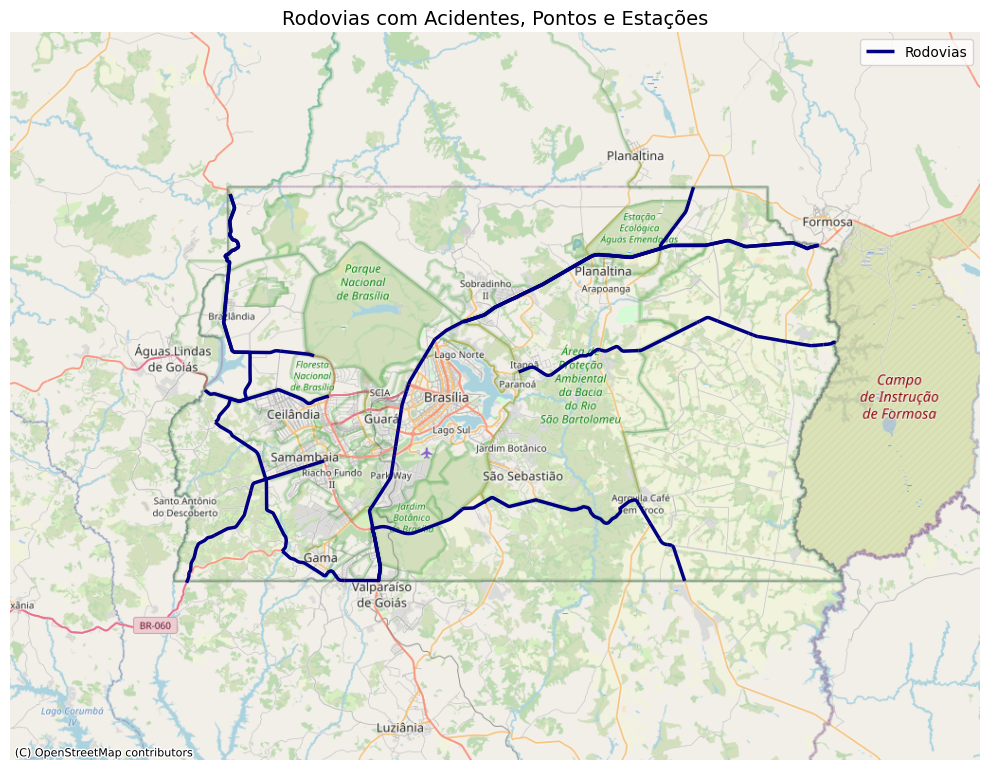

In [24]:
# Caminho para o arquivo zip com shapefile
arquivo_zip = "data/geoloc/202504A.zip"
gdf = gpd.read_file(f"zip://{arquivo_zip}")
brs_geo = gdf['vl_br'].unique().tolist()

# Filtro paraq trechos no DF
cond_df = gdf['sg_uf'].str.strip().str.lower()=='df'
gdf = gdf[cond_df].reset_index(drop=True)

print(f'Nro total de BRs na base: {len(brs_geo)}.')
print(f'Nro de rodovias com trechos no DF: {gdf["vl_br"].nunique()}')

plot_brs(gdf, highway_color='navy')

100%|██████████| 27/27 [00:01<00:00, 21.90it/s]


Nro de estradas com acidentes no DF: 2


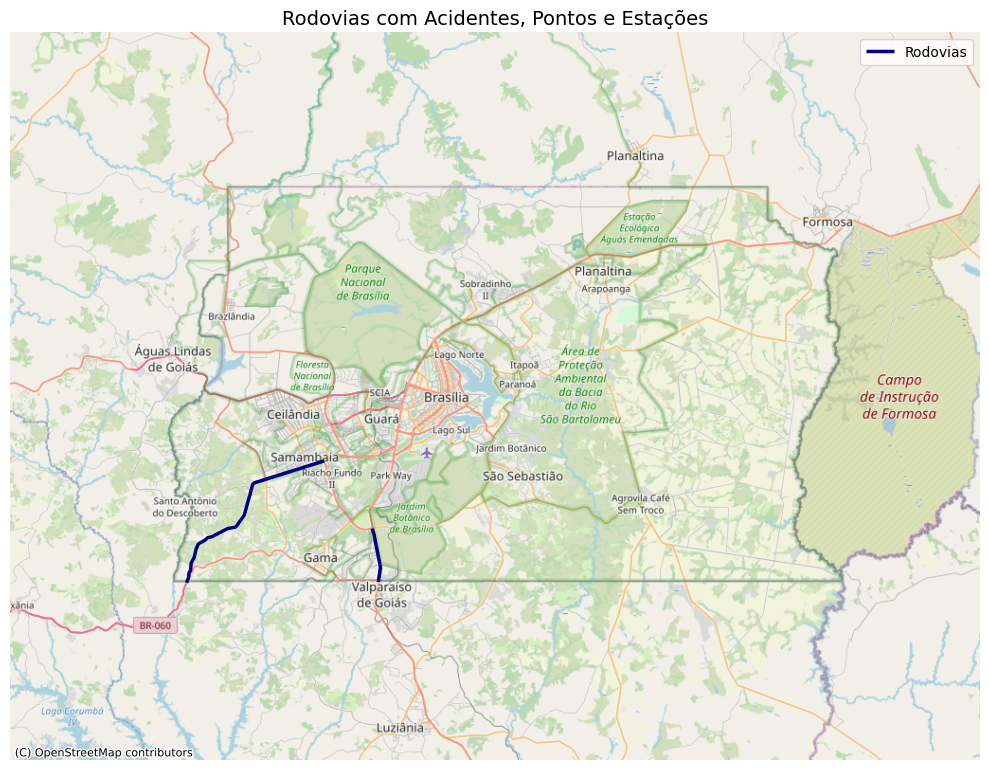

In [25]:
def is_float(value):
    try:
        float(value)
        return True
    except:
        return False

def agrega_csvs_em_df(diretorio: str) -> pd.DataFrame:
    """
    Agrega todos os arquivos CSV de um diretório em um único DataFrame.

    Parâmetros:
    diretorio (str): Caminho do diretório com os CSVs.

    Retorna:
    pd.DataFrame: DataFrame consolidado com todos os arquivos.
    """

    todos_csvs = glob.glob(os.path.join(diretorio, '*.csv'))

    df_list = []

    for arquivo_csv in tqdm(todos_csvs):
        df_temp = pd.read_csv(
            arquivo_csv,
            encoding='latin1',
            sep=';', 
            decimal=',', 
            dtype=str,
            on_bad_lines='warn'
        )
        df_list.append(df_temp)

    df_final = pd.concat(df_list, ignore_index=True)
    df_final['trecho'] = df_final['trecho'].str.strip()
    df_final = df_final.replace(',', '.', regex=True)

    return df_final
    
# Dados de acidentes
df_acidentes = agrega_csvs_em_df('data/acidentes')

# Condições para rodovias no DF que estao na base geo
cond_br = df_acidentes['trecho'].str.lower().str[:2]=='br'
cond_df = df_acidentes['trecho'].str.lower().str[-2:]=='df'
cond_geo = df_acidentes['trecho'].str[3:6].isin(brs_geo)

# Filtro BR, DF e estrada no dataset de geolocalização
cond_filter = ((cond_br & cond_df) & (cond_geo))
df_acidentes = df_acidentes[cond_filter].copy().reset_index(drop=True)
brs_abordadas = df_acidentes['trecho'].str[3:6].unique().tolist()
gdf_brs = gdf[gdf["vl_br"].isin(brs_abordadas)]

# Tratamento tipo
df_acidentes['tipo_de_ocorrencia'] = df_acidentes['tipo_de_ocorrencia'].fillna('Não informado')

base_extent = gdf.to_crs(epsg=3857).total_bounds  # [minx, miny, maxx, maxy]
print(f"Nro de estradas com acidentes no DF: {len(brs_abordadas)}")
plot_brs(gdf_brs, highway_color='navy', highway_linewidth=2.5, extent=base_extent)


Preparando geometrias das rodovias...
Geometrias das rodovias preparadas.
Processando 4382 acidentes...


Localizando acidentes: 100%|██████████| 4382/4382 [00:04<00:00, 949.40it/s] 




init_range: 2014-09-04 04:00:00+00:00, end_range: 2025-04-30 13:00:00+00:00


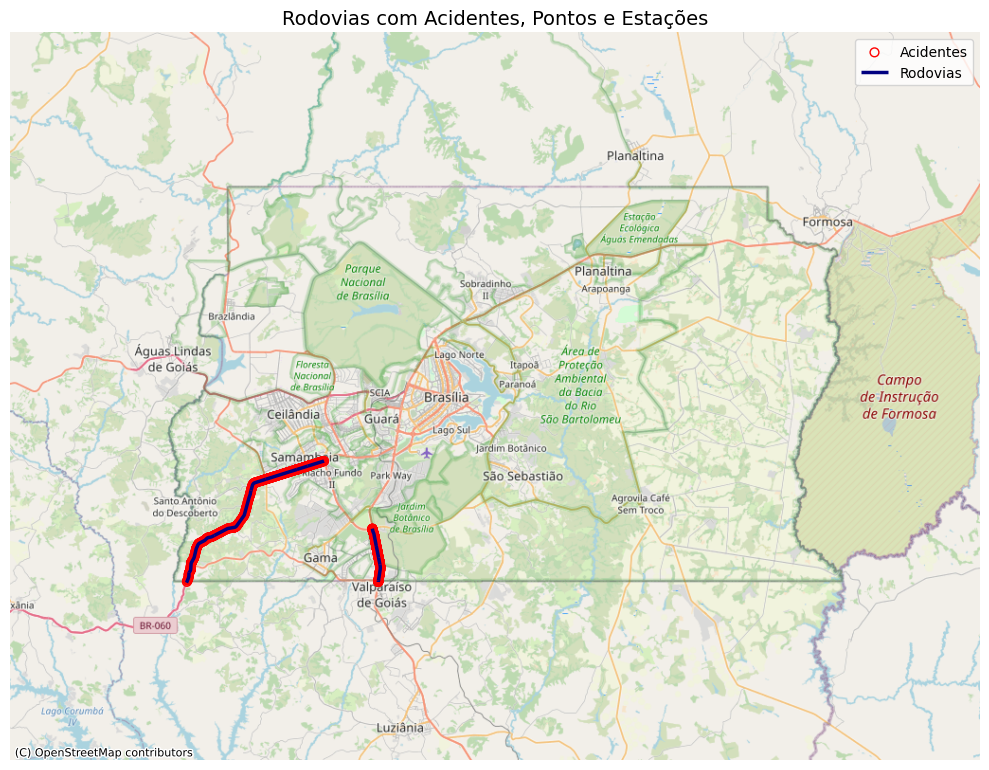

In [26]:
def encontrar_lat_lon_acidentes(geodf_rodovias: gpd.GeoDataFrame, df_acidentes: pd.DataFrame) -> pd.DataFrame:
    print("Preparando geometrias das rodovias...")
    rodovias_dict = {}
    for br_id in geodf_rodovias['vl_br'].unique():
        segmentos_br = geodf_rodovias[geodf_rodovias['vl_br'] == br_id]['geometry'].tolist()
        merged_line = linemerge(segmentos_br)
        if merged_line.geom_type == 'MultiLineString':
            longest_line = None
            max_length = -1
            for line in merged_line.geoms:
                if line.length > max_length:
                    max_length = line.length
                    longest_line = line
            rodovias_dict[br_id] = longest_line
        else: # Já é uma LineString
            rodovias_dict[br_id] = merged_line
    print("Geometrias das rodovias preparadas.")

    # Adiciona colunas para latitude e longitude ao DataFrame de acidentes
    df_acidentes['latitude_acidente'] = None
    df_acidentes['longitude_acidente'] = None

    print(f"Processando {len(df_acidentes)} acidentes...")
    for index, row in tqdm(df_acidentes.iterrows(), total=len(df_acidentes), desc="Localizando acidentes"):
        br_do_acidente = str(row['vl_br'])
        km_do_acidente = row['km']

        if br_do_acidente in rodovias_dict and rodovias_dict[br_do_acidente] is not None:
            rodovia_geom = rodovias_dict[br_do_acidente]
            if geodf_rodovias.crs is None:
                 print("Atenção: CRS das rodovias não definido. Assumindo EPSG:4326.")
                 geodf_rodovias = geodf_rodovias.set_crs("EPSG:4326", allow_override=True)
            if rodovia_geom.is_empty:
                continue # Pula se a geometria estiver vazia

            try:
                # Cria um GeoSeries temporário para a rodovia para facilitar a reprojeção
                rodovia_gseries = gpd.GeoSeries([rodovia_geom], crs=geodf_rodovias.crs)
                rodovia_gseries_proj = rodovia_gseries.to_crs(epsg=32723) # Reprojeta para UTM 23S (metros)
                rodovia_proj = rodovia_gseries_proj.iloc[0]

                # Comprimento total da rodovia em metros
                total_length_meters = rodovia_proj.length

                if total_length_meters == 0:
                    continue
                if km_do_acidente * 1000 > total_length_meters:
                    point_on_line_proj = rodovia_proj.interpolate(min(km_do_acidente * 1000, total_length_meters))
                else:
                    point_on_line_proj = rodovia_proj.interpolate(km_do_acidente * 1000)

                # Transforma o ponto encontrado de volta para lat/lon (EPSG:4326)
                point_gseries = gpd.GeoSeries([point_on_line_proj], crs=32723)
                point_latlon = point_gseries.to_crs(epsg=4326).iloc[0]

                df_acidentes.at[index, 'latitude_acidente'] = point_latlon.y
                df_acidentes.at[index, 'longitude_acidente'] = point_latlon.x

            except Exception as e:
                print(f"Erro ao processar acidente no KM {km_do_acidente} na BR {br_do_acidente}: {e}")
                # As colunas permanecerão None (ou NaN se você preferir)
                df_acidentes.at[index, 'latitude_acidente'] = pd.NA
                df_acidentes.at[index, 'longitude_acidente'] = pd.NA
        else:
            # print(f"Rodovia {br_do_acidente} não encontrada ou geometria inválida no GeoDataFrame de rodovias.")
            df_acidentes.at[index, 'latitude_acidente'] = pd.NA
            df_acidentes.at[index, 'longitude_acidente'] = pd.NA
    return df_acidentes

df_acidentes['km'] = df_acidentes['km'].astype(float)
df_acidentes['n_da_ocorrencia'] = df_acidentes['n_da_ocorrencia'].astype(float).astype(int)
df_acidentes['vl_br'] = df_acidentes['trecho'].str.extract(r'BR-(\d{3})')

df_acidentes['timestamp_utc'] = pd.to_datetime(
    df_acidentes['data'] + ' ' + df_acidentes['horario'],
    format='%d/%m/%Y %H:%M:%S'
).dt.tz_localize('America/Sao_Paulo').dt.tz_convert('UTC')

numeric_cols = [
'automovel', 'bicicleta', 'caminhao', 'moto', 'onibus', 'outros',
'tracao_animal', 'transporte_de_cargas_especiais', 'trator_maquinas',
'utilitarios', 'ilesos', 'levemente_feridos', 'moderadamente_feridos',
'gravemente_feridos', 'mortos'
]
df_acidentes[numeric_cols] = df_acidentes[numeric_cols].apply(pd.to_numeric, errors='coerce')
df_acidentes[numeric_cols] = df_acidentes[numeric_cols].astype(int)

# Obter latitude e longitude dos acidentes
df_acidentes = encontrar_lat_lon_acidentes(gdf_brs, df_acidentes)

init_range = df_acidentes['timestamp_utc'].min().floor('h') - pd.Timedelta(hours=1)
end_range = df_acidentes['timestamp_utc'].max().ceil('h') + pd.Timedelta(hours=1)


print(f'\n\ninit_range: {init_range}, end_range: {end_range}')
plot_brs(
    gdf_brs, 
    df_acidentes.drop_duplicates(subset=['latitude_acidente', 'longitude_acidente']),
    extent=base_extent,
    highway_color='navy',
    accident_linewidth=1,
    accident_markersize=40,
)

# Descobrir latitude e longitude média dos acidentes e da rodovia
- muito proximas entre si e de Gama

In [27]:
def extract_line_vertices(
    gdf,
    id_field='id_trecho_',
    br_field='vl_br',
    output_crs="EPSG:4326"
):
    """
    Extrai todos os vértices de um GeoDataFrame de linhas e retorna:
      - df_coords: DataFrame com colunas [id_field, br_field, longitude, latitude]
      - gdf_points: GeoDataFrame de pontos no mesmo CRS de saída

    Parâmetros:
    - gdf: GeoDataFrame de linhas (qualquer CRS).
    - id_field: nome da coluna que identifica cada trecho.
    - br_field: nome da coluna com o código da BR.
    - output_crs: CRS em que as coordenadas devem ser retornadas (padrão EPSG:4326).

    Retorna:
    - df_coords (pd.DataFrame)
    - gdf_points (gpd.GeoDataFrame)
    """
    # 1) Reprojeta para o CRS de saída
    gdf_ll = gdf.to_crs(output_crs)

    # 2) Função interna para extrair coords de LineString e MultiLineString
    def _coords_from_geom(geom):
        if isinstance(geom, LineString):
            return list(geom.coords)
        elif isinstance(geom, MultiLineString):
            coords = []
            for segment in geom.geoms:
                coords.extend(segment.coords)
            return coords
        else:
            return []

    # 3) Itera e acumula
    records = []
    for _, row in gdf_ll.iterrows():
        for lon, lat in _coords_from_geom(row.geometry):
            records.append({
                id_field: row[id_field],
                br_field: row[br_field],
                'longitude': lon,
                'latitude': lat
            })

    df_coords = pd.DataFrame(records)

    # 4) Converte para GeoDataFrame de pontos
    gdf_points = gpd.GeoDataFrame(
        df_coords,
        geometry=gpd.points_from_xy(df_coords.longitude, df_coords.latitude),
        crs=output_crs
    )

    return df_coords, gdf_points


df_coords_brs, _ = extract_line_vertices(gdf_brs)
print(f"Pto_m_BRs: \n{df_coords_brs[['latitude', 'longitude']].mean()}.\n\nPto_m_acidentes: \n{df_acidentes[['latitude_acidente', 'longitude_acidente']].mean()}")

Pto_m_BRs: 
latitude    -15.966823
longitude   -48.117192
dtype: float64.

Pto_m_acidentes: 
latitude_acidente    -15.970832
longitude_acidente   -48.074939
dtype: object


# Obter malha de estações automáticas
- Scan feito em 10mil arquivos (relativamente demorado)
- Correção de valores faltantes com base no próprio mapeamento (ficam algumas altitudes faltantes)
- Correção final de altitudes via SRTM

- Encontradas 616 estações

In [28]:
# Carrega o DEM SRTM
elevation_data = srtm.get_data()

# Função que preenche altitude apenas se for NaN ou 0.0
def fetch_alt(row):
    if pd.isna(row['altitude']) or row['altitude'] == 0.0:
        alt = elevation_data.get_elevation(row['latitude'], row['longitude'])
        return float(alt) if alt is not None else 0.0
    return row['altitude']

# Função que varre os CSVs do INMET e extrai metadados -> obter dados das estações
def scan_inmet_stations(root_dir: str) -> pd.DataFrame:
    """
    Varre todos os CSVs em root_dir e, para cada arquivo, lê apenas as 8 primeiras linhas
    para extrair:
      - REGIAO, UF, ESTACAO, CODIGO (WMO), LATITUDE, LONGITUDE, ALTITUDE, DATA DE FUNDACAO
    Converte lat/long/alt de string 'x,y' para float x.y e normaliza
    DATA DE FUNDACAO de DD/MM/YY para YYYY-MM-DD.
    Retorna um DataFrame com uma linha por arquivo.
    """
    records = []
    files = list(Path(root_dir).rglob("*.[cC][sS][vV]"))
    for csv_path in tqdm(files, desc="Scanning CSVs", total=len(files)):
        year = csv_path.parent.name
        meta = {}
        
        # Sample encoding detection
        raw = csv_path.read_bytes()[:2048]
        enc = chardet.detect(raw)['encoding'] or 'latin1'

        # lê só as 8 primeiras linhas
        with open(csv_path, encoding=enc) as f:
            for i, line in enumerate(f):
                if i >= 8:
                    break
                line = line.strip()
                if not line:
                    continue
                # separa chave e valor em "KEY:;VALUE"
                parts = line.split(";", 1)
                if len(parts) < 2:
                    continue
                key = unidecode(parts[0].rstrip(":").strip().lower())
                val = unidecode(parts[1].strip().lower())
                
                # Tratamento especial para chaves e valores
                if 'yyyy-mm-dd' in key:
                    key = key.replace("(yyyy-mm-dd)", "").strip()
                    val = f'{val[8:]}/{val[5:7]}/{val[2:4]}'  # DD/MM/YY
                if 'c?' in key:
                    key = key.replace("c?", "ca").strip()
                
                meta[key] = val

        # converte lat, lon, altitude para float
        lat = float(meta["latitude"].replace(",", "."))
        lon = float(meta["longitude"].replace(",", "."))
        try:
            alt = float(meta["altitude"].replace(",", "."))
        except:
            alt = np.nan

        # converte DATA DE FUNDACAO de DD/MM/YY para YYYY-MM-DD
        # ex: "21/10/06" → "2006-10-21"

        dt = datetime.strptime(meta["data de fundacao"], "%d/%m/%y")
        foundation_date = dt.strftime("%Y-%m-%d")

        records.append({
            "file":             str(csv_path),
            "year":             year,
            "region":           meta.get("regiao"),
            "uf":               meta.get("uf"),
            "station_name":     meta.get("estacao"),
            "wmo_code":         meta.get("codigo (wmo)"),
            "latitude":         lat,
            "longitude":        lon,
            "altitude":         alt,
            "foundation_date":  foundation_date,
        })
    
    df = pd.DataFrame(records)
    
    # Drop duplicates based on WMO code -> preterindo amosstras com dados faltantes
    df["_completude"] = df.notnull().sum(axis=1)
    df = df.sort_values(["wmo_code", "_completude"], ascending=[True, False])
    df = df.drop_duplicates(subset="wmo_code", keep="first")
    df = df.drop(columns="_completude").reset_index(drop=True)
    
    # Preenchimento de dados faltantes de altura
    df['altitude'] = df.apply(fetch_alt, axis=1)
    
    # Coluna para hover_name
    df['name (wmo)'] = df['station_name'] + ' (' + df['wmo_code'] + ')'
    
    return df.drop(columns=["file"])

# Get and Save
root = "data/meteorologia"
df_estacoes = scan_inmet_stations(root)

print(df_estacoes.shape)
df_estacoes.head()

Scanning CSVs: 100%|██████████| 10022/10022 [00:46<00:00, 217.02it/s]


(616, 10)


year region  uf station_name wmo_code   latitude  longitude  altitude  \
0  2016     co  df     brasilia     a001 -15.789444 -47.925833   1159.54   
1  2016     co  go      goiania     a002 -16.642778 -49.220000    770.00   
2  2016     co  go    morrinhos     a003 -17.716667 -49.100000    771.42   
3  2023     co  go    porangatu     a005 -13.309444 -49.117500    365.00   
4  2016      n  to       palmas     a009 -10.183333 -48.300000    280.00   

  foundation_date        name (wmo)  
0      2000-05-07   brasilia (a001)  
1      2001-05-29    goiania (a002)  
2      2001-05-25  morrinhos (a003)  
3      2001-06-04  porangatu (a005)  
4      2004-12-17     palmas (a009)

In [29]:
fig = px.scatter_map(
    df_estacoes,
    lat="latitude",
    lon="longitude",
    zoom=4,
    height=400,
    width=700,
    map_style="open-street-map", 
    title="Estações Meteorológicas no Brasil",
    hover_name="name (wmo)" 
)

fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    mapbox_center={"lat": -14.235, "lon": -51.9253} # Centraliza no Brasil
)

fig.show()

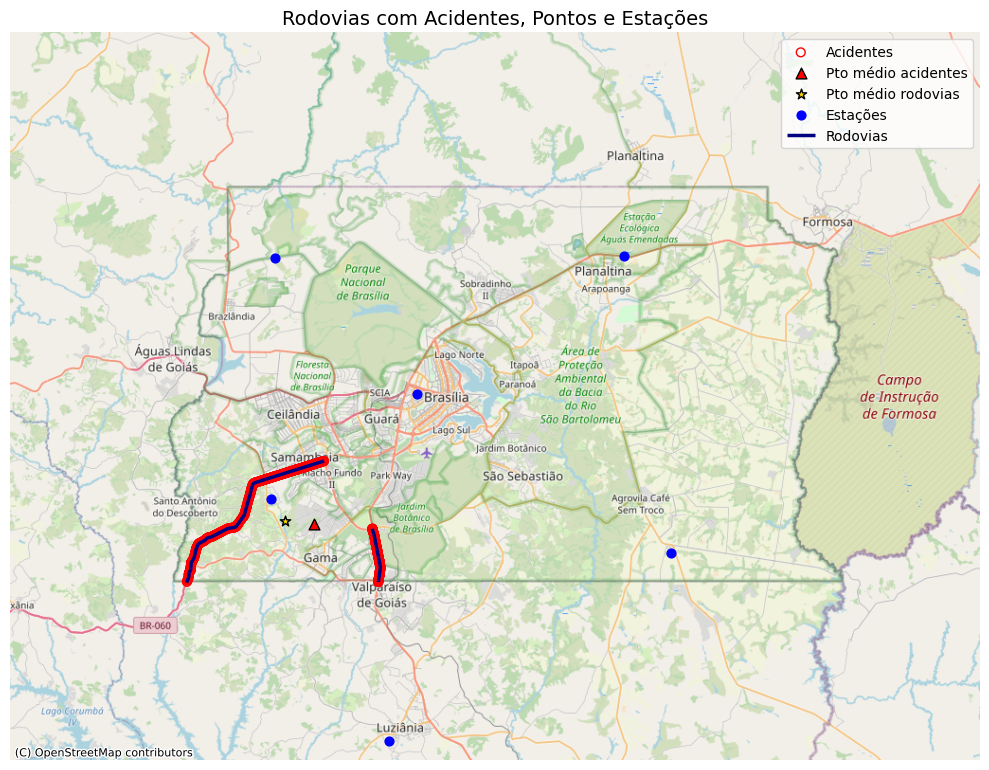

In [30]:
points = [df_acidentes[['latitude_acidente', 'longitude_acidente']].mean().tolist() + ['Pto médio acidentes', 'red', '^']]
points += [df_coords_brs[['latitude', 'longitude']].mean().tolist() + ['Pto médio rodovias', 'gold', '*']]
plot_brs(
    gdf_brs, 
    df_acidentes.drop_duplicates(subset=['latitude_acidente', 'longitude_acidente']),
    points_list=points,
    extent=base_extent,
    highway_color='navy',
    accident_linewidth=1,
    accident_markersize=40,
    df_estacoes=df_estacoes,
    # extent = 'auto'
)

# Confimação de estações mais próximas
- 1ra Gama
- 2da Brasilia

In [31]:
def estacao_mais_proxima(points, df_estacoes):
    resultados = []

    for lat_p, lon_p, desc_p, *_ in points:
        ponto_ref = (lat_p, lon_p)
        melhor_dist = float("inf")
        melhor_est  = None

        # Avalia cada estação
        for _, est in df_estacoes.iterrows():
            ponto_est = (est["latitude"], est["longitude"])
            dist_km   = geodesic(ponto_ref, ponto_est).km

            if dist_km < melhor_dist:
                melhor_dist = dist_km
                melhor_est  = est

        resultados.append({
            "point_desc":   desc_p,
            "point_lat":    lat_p,
            "point_lon":    lon_p,
            "station":   melhor_est['name (wmo)'],
            "station_lat":  melhor_est["latitude"],
            "station_lon":  melhor_est["longitude"],
            "dist_km":      round(melhor_dist, 3)
        })

    return pd.DataFrame(resultados)

nearest_df = estacao_mais_proxima(points, df_estacoes)
wmo = nearest_df.loc[1,'station'].split('(')[-1].replace(')','')
second_nearest_df = estacao_mais_proxima(points, df_estacoes[df_estacoes['wmo_code']!=wmo])
second_wmo = second_nearest_df.loc[1,'station'].split('(')[-1].replace(')','')

print(wmo, second_wmo)

display(nearest_df)
second_nearest_df

a046 a001


point_desc  point_lat  point_lon                   station  \
0  Pto médio acidentes -15.970832 -48.074939  gama (ponte alta) (a046)   
1   Pto médio rodovias -15.966823 -48.117192  gama (ponte alta) (a046)   

   station_lat  station_lon  dist_km  
0   -15.935278     -48.1375    7.768  
1   -15.935278     -48.1375    4.112

point_desc  point_lat  point_lon          station  station_lat  \
0  Pto médio acidentes -15.970832 -48.074939  brasilia (a001)   -15.789444   
1   Pto médio rodovias -15.966823 -48.117192  brasilia (a001)   -15.789444   

   station_lon  dist_km  
0   -47.925833   25.649  
1   -47.925833   28.378

# Obter propriedades meteorológicas da estrada
## Calculo pesado. Estratégia
- Propriedades da wmo mais proxima: -> preenche a grande maioria do intervalo temporal
- Corta bordas faltantes (inicio e fim dos periodos não preenchidos - head e tail - caso nao esteja preenchido)
- Preenchimento de radiação nula noturna
- Interpolação quando o valor faltante tem vizinhos imediatos preenchidos

In [32]:
def trim_empty_rows(df_input: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df_input.replace(-9999, np.nan)

    first_valid_idx = 0
    for i in range(len(df_cleaned)):
        if df_cleaned.iloc[i].isna().all():
            first_valid_idx += 1
        else:
            break

    last_valid_idx = len(df_cleaned) - 1
    for i in range(len(df_cleaned) - 1, -1, -1):
        if df_cleaned.iloc[i].isna().all():
            last_valid_idx -= 1
        else:
            break

    if first_valid_idx > last_valid_idx:
        return pd.DataFrame(columns=df_cleaned.columns)
    else:
        return df_cleaned.iloc[first_valid_idx : last_valid_idx + 1]
    
def fill_night_rad(df: pd.DataFrame, rad_col: str = 'RADIACAO GLOBAL (KJ/m²)') -> pd.DataFrame:
    """
    Preenche valores faltantes (-9999 ou NaN) na coluna de radiação global com 0
    durante o período noturno (22h UTC a 8h UTC, que corresponde a 19h BRT a 5h BRT).

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados de radiação com timestamp_utc como índice.
        rad_col (str): O nome da coluna de radiação global. Padrão é 'RADIACAO GLOBAL (KJ/m²)'.

    Returns:
        pd.DataFrame: O DataFrame com os valores de radiação noturna faltantes preenchidos.
    """

    # Certifica-se de que o índice é datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("O índice do DataFrame deve ser do tipo DatetimeIndex.")

    df_copy = df.copy() # Trabalhe em uma cópia para não alterar o DF original diretamente

    # Horas UTC que correspondem ao período noturno em Brasília (19h-6h BRT ~ 22h-9h UTC)
    # Incluindo 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8 [19h as 5h]
    night_hours_utc = list(range(22, 24)) + list(range(0, 10))

    # Identifica as linhas que estão no período noturno
    is_night_time = df_copy.index.hour.isin(night_hours_utc)

    # Identifica onde os valores de radiação são -9999 ou NaN
    is_missing_or_9999 = (df_copy[rad_col] == -9999.) | df_copy[rad_col].isna()

    # Combina as condições: é noite E o valor está faltando/é -9999
    condition_to_fill = is_night_time & is_missing_or_9999

    # Preenche com 0 apenas onde a condição é verdadeira
    df_copy.loc[condition_to_fill, rad_col] = 0

    return df_copy

def fill_missing_with_neighbors_mean(df: pd.DataFrame, missing_values: list = [-9999, np.nan]) -> pd.DataFrame:
    """
    Preenche dados faltantes (NaN ou -9999) em cada coluna de um DataFrame
    com a média dos valores imediatamente anterior e posterior, arredondada para 1 casa decimal,
    SOMENTE se ambos os vizinhos estiverem presentes e válidos.

    Args:
        df (pd.DataFrame): O DataFrame a ser processado.
        missing_values (list): Uma lista de valores a serem considerados como faltantes.
                               Padrão é [-9999, np.nan].

    Returns:
        pd.DataFrame: O DataFrame com os valores faltantes preenchidos.
    """

    df_filled = df.copy() # Trabalhe em uma cópia para não alterar o DF original

    # Convertendo a lista de valores faltantes para um formato fácil de verificar
    # np.nan precisa ser tratado separadamente com pd.isna()
    numeric_missing_values = [v for v in missing_values if v != np.nan]
    check_nan = np.nan in missing_values

    # Iterar sobre cada coluna numérica do DataFrame
    for col in df_filled.select_dtypes(include=np.number).columns:
        for i in range(1, len(df_filled) - 1): # Começamos de 1 e vamos até len-2 para ter vizinhos
            current_value = df_filled.loc[df_filled.index[i], col]

            is_current_missing = False
            if pd.isna(current_value) and check_nan:
                is_current_missing = True
            elif current_value in numeric_missing_values:
                is_current_missing = True

            if is_current_missing:
                prev_value = df_filled.loc[df_filled.index[i-1], col]
                next_value = df_filled.loc[df_filled.index[i+1], col]

                is_prev_valid = True
                if pd.isna(prev_value) and check_nan:
                    is_prev_valid = False
                elif prev_value in numeric_missing_values:
                    is_prev_valid = False

                is_next_valid = True
                if pd.isna(next_value) and check_nan:
                    is_next_valid = False
                elif next_value in numeric_missing_values:
                    is_next_valid = False

                if is_prev_valid and is_next_valid:
                    # Calcular a média e ARREDONDAR PARA 1 CASA DECIMAL
                    df_filled.loc[df_filled.index[i], col] = round((prev_value + next_value) / 2, 1)

    return df_filled

def _to_same_tz(ts_like, target_tz):
    """
    Recebe algo que vira Timestamp e o converte para o mesmo timezone de `target_tz`.
    - Se já vier com tz, faz .tz_convert(...)
    - Se vier sem tz (naive), faz .tz_localize(target_tz)
    """
    ts = pd.to_datetime(ts_like)

    if target_tz is None:                     # índice é naive → devolve naive
        return ts.tz_localize(None)

    if ts.tzinfo is None:                     # parâmetro é naive → localiza
        return ts.tz_localize(target_tz)

    # parâmetro já tem tz → converte
    return ts.tz_convert(target_tz)

def recorte_horario(df: pd.DataFrame, init_range, end_range):
    """
    Recorta `df` entre init_range e end_range (>=, <=) e devolve todas as horas
    do intervalo, preenchendo lacunas com NaN. Compatível com índices com ou sem tz.
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("O índice do DataFrame precisa ser DateTimeIndex.")

    tz_index = df.index.tz                   # None → naive, senão aware (UTC, etc.)

    # 1) Converte limites para o mesmo tz do índice
    ini = _to_same_tz(init_range, tz_index)
    fim = _to_same_tz(end_range,  tz_index)

    # 2) Ordena
    start, stop = sorted([ini, fim])

    # 3) Recorte >=, <=
    recorte = df.loc[(df.index >= start) & (df.index <= stop)]

    # 4) Índice horário completo
    full_idx = pd.date_range(start, stop, freq="h", tz=tz_index)
    return recorte.reindex(full_idx)

def fill_with_hour_means(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preenche NaNs usando a média da mesma hora (0–23), calculada apenas
    sobre dias sem nenhum valor faltante.

    Parâmetros
    ----------
    df : DataFrame
        Deve ter DateTimeIndex de frequência horária (timezone naive ou aware).

    Retorno
    -------
    DataFrame
        Cópia do df com NaNs preenchidos.
    """

    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("O DataFrame precisa ter DateTimeIndex.")

    # 1) Garante frequência horária contínua
    df = df.sort_index().asfreq("h")

    # 2) Identifica dias íntegros (24 linhas / 0 NaNs em todas as colunas)
    #    -> cria Series booleana com um valor por dia
    by_day = df.isna().any(axis=1).groupby(df.index.normalize())
    good_days_mask = ~by_day.transform("any")       # True para linhas de dias íntegros
    good_days = df[good_days_mask]

    # 3) Calcula média por hora (0–23) usando somente os dias íntegros
    hourly_means = good_days.groupby(good_days.index.hour).mean()

    # 4) Função auxiliar: preenche uma linha usando hourly_means
    def _fill_row(row):
        hour = row.name.hour
        return row.fillna(hourly_means.loc[hour])

    # 5) Aplica ao DataFrame inteiro
    df_filled = df.apply(_fill_row, axis=1).round(1)

    return df_filled

def get_wmo(wmo):
    colum_met = ['DATA (YYYY-MM-DD)',
    'HORA (UTC)',
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
    'RADIACAO GLOBAL (KJ/m²)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))',
    'VENTO, RAJADA MAXIMA (m/s)',
    'VENTO, VELOCIDADE HORARIA (m/s)',
    '']

    files = list(Path(root).rglob("*.[cC][sS][vV]"))
    files = pd.DataFrame(files, columns=['path'])
    files['filename'] = files['path'].apply(lambda x: x.name)
    files['WMO'] = files['filename'].str.split('_').str[3].str.lower()
    data = []
    wmo_files = files[files['WMO'] == wmo]['path'].tolist()
    # Sample encoding detection
    for csv_path in tqdm(wmo_files):
        raw = csv_path.read_bytes()[:2048]
        enc = chardet.detect(raw)['encoding'] or 'latin1'
        with open(csv_path, encoding=enc) as f:
            for i, line in enumerate(f):
                if i == 8:
                    data_type = line.split(';')[0].strip().lower()
                if i > 8:
                    values = line.split(';')
                    if 'yyyy-mm-dd' not in data_type:
                        values[0] = values[0].replace('/', '-')
                    if 'utc' in values[1].lower():
                        values[1] = values[1].strip()[:2] + ':00'
                    data.append(values)
    df_wmo = pd.DataFrame(data, columns=colum_met)[colum_met[:-1]]
    df_wmo.replace(',','.', regex=True, inplace=True)
    df_wmo.replace(' ','', regex=True, inplace=True)
    df_wmo.replace('',np.nan, regex=True, inplace=True)
    df_wmo.replace('-9999',np.nan, regex=True, inplace=True)

    # indexação temporal
    df_wmo['timestamp_utc'] = pd.to_datetime(df_wmo['DATA (YYYY-MM-DD)'] + ' ' + df_wmo['HORA (UTC)'])
    df_wmo = df_wmo.set_index('timestamp_utc')
    df_wmo = df_wmo.drop(columns=['DATA (YYYY-MM-DD)', 'HORA (UTC)']).sort_index()

    # # Cortar bordas ausentes
    df_wmo = trim_empty_rows(df_wmo).astype(float)

    # Preencher radiação noturna (obsevação anterior)
    df_wmo = fill_night_rad(df_wmo)

    # Recorte de tempo definido
    df_wmo = recorte_horario(df_wmo, init_range, end_range)

    # Interpolação quando o valor faltante tem vizinhos imediatos preenchidos
    df_wmo = fill_missing_with_neighbors_mean(df_wmo)


    return df_wmo



In [33]:
df_met_br = get_wmo(wmo)
df_met_br.head()

100%|██████████| 12/12 [00:00<00:00, 46.89it/s]


PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
2014-09-04 04:00:00                               NaN   
2014-09-04 05:00:00                               NaN   
2014-09-04 06:00:00                               NaN   
2014-09-04 07:00:00                               NaN   
2014-09-04 08:00:00                               NaN   

                     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
2014-09-04 04:00:00                                                NaN       
2014-09-04 05:00:00                                                NaN       
2014-09-04 06:00:00                                                NaN       
2014-09-04 07:00:00                                                NaN       
2014-09-04 08:00:00                                                NaN       

                     PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
2014-09-04 04:00:00                                              NaN   
2014-09-04 05:00:00                                              NaN   
2014-09-04 06:00:00                                              NaN   
2014-09-04 07:00:00                                              NaN   
2014-09-04 08:00:00                                              NaN   

                     PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  \
2014-09-04 04:00:00                                               NaN   
2014-09-04 05:00:00                                               NaN   
2014-09-04 06:00:00                                               NaN   
2014-09-04 07:00:00                                               NaN   
2014-09-04 08:00:00                                               NaN   

                     RADIACAO GLOBAL (KJ/m²)  \
2014-09-04 04:00:00                      NaN   
2014-09-04 05:00:00                      NaN   
2014-09-04 06:00:00                      NaN   
2014-09-04 07:00:00                      NaN   
2014-09-04 08:00:00                      NaN   

                     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
2014-09-04 04:00:00                                           NaN   
2014-09-04 05:00:00                                           NaN   
2014-09-04 06:00:00                                           NaN   
2014-09-04 07:00:00                                           NaN   
2014-09-04 08:00:00                                           NaN   

                     TEMPERATURA DO PONTO DE ORVALHO (°C)  \
2014-09-04 04:00:00                                   NaN   
2014-09-04 05:00:00                                   NaN   
2014-09-04 06:00:00                                   NaN   
2014-09-04 07:00:00                                   NaN   
2014-09-04 08:00:00                                   NaN   

                     TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  \
2014-09-04 04:00:00                                         NaN   
2014-09-04 05:00:00                                         NaN   
2014-09-04 06:00:00                                         NaN   
2014-09-04 07:00:00                                         NaN   
2014-09-04 08:00:00                                         NaN   

                     TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)  \
2014-09-04 04:00:00                                         NaN   
2014-09-04 05:00:00                                         NaN   
2014-09-04 06:00:00                                         NaN   
2014-09-04 07:00:00                                         NaN   
2014-09-04 08:00:00                                         NaN   

                     TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)  \
2014-09-04 04:00:00                                               NaN   
2014-09-04 05:00:00                                               NaN   
2014-09-04 06:00:00                                               NaN   
2014-09-04 07:00:00                                               NaN   
2014-09-04 08:00:00                                               NaN   

                     

In [34]:
df_met_br.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93394 entries, 2014-09-04 04:00:00 to 2025-04-30 13:00:00
Freq: h
Data columns (total 17 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       91420 non-null  float64
 1   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  90298 non-null  float64
 2   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        90273 non-null  float64
 3   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       90273 non-null  float64
 4   RADIACAO GLOBAL (KJ/m²)                                91173 non-null  float64
 5   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           91755 non-null  float64
 6   TEMPERATURA DO PONTO DE ORVALHO (°C)                   91755 non-null  float64
 7   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)             91730 non-null  float64
 8   TEM

# Preenchimentos de ajuste particular
- Poucos casos nao preenchidos -> usa dados da segunda estação mais próxima
- Pouquissimos casos restantes sem preenchimento (menos de dezena de rows): preenche com a média do dataset

In [35]:
df_wmo2 = get_wmo(second_wmo)
df_wmo2.head(1)

100%|██████████| 26/26 [00:00<00:00, 38.64it/s]


PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
2014-09-04 04:00:00                               0.0   

                     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
2014-09-04 04:00:00                                              887.5       

                     PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
2014-09-04 04:00:00                                            887.9   

                     PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  \
2014-09-04 04:00:00                                             887.5   

                     RADIACAO GLOBAL (KJ/m²)  \
2014-09-04 04:00:00                      1.6   

                     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
2014-09-04 04:00:00                                          17.8   

                     TEMPERATURA DO PONTO DE ORVALHO (°C)  \
2014-09-04 04:00:00                                  14.6   

                     TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  \
2014-09-04 04:00:00                                        18.9   

                     TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)  \
2014-09-04 04:00:00                                        17.8   

                     TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)  \
2014-09-04 04:00:00                                              14.8   

                     TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)  \
2014-09-04 04:00:00                                              14.0   

                     UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
2014-09-04 04:00:00                                      81.0   

                     UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
2014-09-04 04:00:00                                      73.0   

                     UMIDADE RELATIVA DO AR, HORARIA (%)  \
2014-09-04 04:00:00                                 81.0   

                     VENTO, DIREÇÃO HORARIA (gr) (° (gr))  \
2014-09-04 04:00:00                                  21.0   

                     VENTO, RAJADA MAXIMA (m/s)  \
2014-09-04 04:00:00                         3.6   

                     VENTO, VELOCIDADE HORARIA (m/s)  
2014-09-04 04:00:00                              2.2

In [36]:
# Preenchimento com segunda estação
df_met_br = df_met_br.sort_index()
df_wmo2   = df_wmo2.sort_index()
df_met_br= df_met_br.combine_first(df_wmo2)

# Verifica quantos valores foram preenchidos
faltantes_antes = df_met_br.isna().sum().sum()
faltantes_depois = df_met_br.isna().sum().sum()
print(f"Faltantes antes:  {faltantes_antes}")
print(f"Faltantes depois: {faltantes_depois}")


Faltantes antes:  68
Faltantes depois: 68


In [37]:
# Preenchimento com média
df_met_br_filled = fill_with_hour_means(df_met_br)
print("Depois:", df_met_br_filled.isna().sum().sum())
df_met_br_filled.info()


Depois: 0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93394 entries, 2014-09-04 04:00:00 to 2025-04-30 13:00:00
Freq: h
Data columns (total 17 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       93394 non-null  float64
 1   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  93394 non-null  float64
 2   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        93394 non-null  float64
 3   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       93394 non-null  float64
 4   RADIACAO GLOBAL (KJ/m²)                                93394 non-null  float64
 5   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           93394 non-null  float64
 6   TEMPERATURA DO PONTO DE ORVALHO (°C)                   93394 non-null  float64
 7   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)             93394 non-null  float6

# Save util data

In [39]:
path_util_data = Path("util_data")
path_util_data.mkdir(parents=True, exist_ok=True)

df_estacoes.to_csv(f"{path_util_data}/inmet_stations.csv", index=False, encoding="utf-8-sig")
df_acidentes.to_csv(f"{path_util_data}/acidentes_brs_040_060.csv", index=False)
df_met_br_filled.to_csv(f"{path_util_data}/meteorologia_brs_040_060.csv")